# Toronto Community Health Profile Segmentation by Neighborhood Level #
This is a pilot data science project for clustering neighborhood areas in Toronto characterized by their community health profile. The dataset used in this project is sourced from Ontario Community Health Profiles Partnership.

The page can be found here (http://www.ontariohealthprofiles.ca/)

Dataset is a collection of indicators from multiple data sources to describe the Toronto community health profile by neighborhood areas in Toronto. Indicators are categorized by 10 different categories which include population, socio-demographic, language, marginalization index, primary care, emergency care, hospital admissions, adult health, prevention, injuries, palliative care and birth rate.

**Problem Statement**: members of government agencies in Toronto Local Health Integration Network (TC LHIN), Minisitry of Health (MoH) and City of Toronto are interested in profiling the community health in Toronto at neighborhood level. Basically, this will help them to establish the strategic plan for resource allocation for future fiscal years.

**Potential Stakeholders**:
* Members from Ministry of Health and Long-term Care (MoHLTC)
* Members from Toronto Local Health Integration Network (TC LHIN)
* Members from Public Health Ontario (PHO)
* Members from City of Toronto

**Goal**: Provide the community health group comparison standards which are segemented at neighborhood level. Unlike hospital service providers (i.e., university teaching, pediatric, mental health), there is no clear peer group comparison standard established for community health service providers. Thus, we want to establish the community health profile segmenation at neighborhood level in Toronto. 

**Future Work**:

**Recommendation for Clients**:

In [1]:
# Import all libraries:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn:
sns.set_style('whitegrid')
sns.set_context('poster')

## Data Loading ##
The dataset consists of information on various community health profile at a neighborhood level across Toronto area. The types of features include but not limited to 10 different types of indicator sources (i.e., population, socio-demographics, primary care, emergency care, adult health disease and etc.).

In [2]:
# Load training data: 
df = pd.read_excel('ochpp_train.xlsx', sheet_name='train')
# Map column names to lowercases
df.columns = map(str.lower, df.columns)

# Check the dataframe observations:
df.head()

,nh_id,nh_name,ward_id,ward_name,demo_pct_males,demo_pct_females,inc_pct_lico_at,inc_pct_lim_at,inc_avg_fam_size,inc_pct_econ_no_child,...,health_hosp_rate_1k,health_injury_rate_100,health_pc_mortality_rate_100,demo_birth_rate_1k,health_4_chronic_cond_rate_1k,health_diabetes_rate_100,health_asthma_rate_100,health_hbp_rate_100,health_mh_rate_100,health_copd_rate_100
0,1,West Humber-Clairville,2,Etobicoke North,0.505515,0.494485,0.137462,0.157645,3.608344,0.198630,...,151.624350,18.723404,41.509434,29.611152,14.276676,18.240313,15.880395,29.872023,7.227160,6.836167
1,2,Mount Olive-Silverstone-Jamestown,1,Etobicoke North,0.490776,0.509224,0.217822,0.278446,3.708900,0.141533,...,149.002476,18.414392,34.745763,42.018600,11.074320,18.428755,14.619216,28.466612,8.133318,6.579543
2,3,Thistletown-Beaumond Heights,1,Etobicoke North,0.495343,0.504657,0.146739,0.177866,3.450758,0.232955,...,188.338301,22.488889,48.913043,32.098765,22.447839,17.709979,15.992921,31.797739,8.447794,9.261745
3,4,Rexdale-Kipling,2,Etobicoke North,0.489285,0.510715,0.158860,0.186866,3.240506,0.227848,...,186.855555,22.595420,39.705882,32.824427,20.532592,17.458867,16.712992,31.170018,9.037934,10.466369
4,5,Elms-Old Rexdale,2,Etobicoke North,0.492390,0.507610,0.179270,0.232681,3.374749,0.208417,...,161.560976,22.525970,23.636364,36.413341,15.219512,17.028070,19.024390,28.788080,8.886524,9.702315


In [3]:
# Compute summary statistics:
df_stat = df[['inc_pct_lico_at', 'inc_pct_lim_at', 
              'health_unsch_ed_visits_rate_1k','health_alc_rate_100','health_hosp_rate_1k',
              'health_injury_rate_100','demo_birth_rate_1k','health_4_chronic_cond_rate_1k']].describe().T
# Re-order columns:
df_stat = df_stat[['count','std','min','mean','max','25%','50%','75%']]
# Let's look at features of interest (F.O.I): income, ED visits, birth rate, etc.
df_stat

,count,std,min,mean,max,25%,50%,75%
inc_pct_lico_at,140.0,0.067410,0.043052,0.169198,0.364531,0.128557,0.162379,0.202697
inc_pct_lim_at,140.0,0.079417,0.047411,0.195463,0.455484,0.139614,0.185219,0.238974
health_unsch_ed_visits_rate_1k,140.0,134.388249,407.929880,675.632194,1214.544690,573.319707,676.251034,763.137882
health_alc_rate_100,140.0,4.359139,6.052315,14.858917,28.447434,11.479682,14.667835,17.434515
health_hosp_rate_1k,140.0,20.306348,97.393071,144.959959,190.899059,129.832533,144.892319,158.018407
health_injury_rate_100,140.0,2.973981,12.614535,20.956995,30.726325,18.922906,21.016759,22.764754
demo_birth_rate_1k,140.0,6.930402,16.106391,30.940188,55.055888,26.698164,31.284402,36.052800
health_4_chronic_cond_rate_1k,140.0,4.904897,9.085541,19.242655,37.392204,16.352407,18.838607,21.241809


# Feature Transformation #
**Feature encoding** is a process where features are encoded into right data format. Oridinal feature encoding will be applied on the likert scale measures which contains information about "order/magnitude" such as likelihood (i.e., score, level, etc.). 

**Stratification** is a process where numerical features get divided into group based on the specified range(s). 

In [4]:
# Ordinal Feature Encoding #
# Define the likert scale of ON Marginalization Index Features: avg_instability_scale, ... , avg_ethnic_scale
instability_map = {1: '1-least instable', 2: '2-little instable', 
                   3: '3-neutral instable', 4: '4-somewhat instable', 5: '5-most instable'}
deprivation_map = {1: '1-least deprived', 2: '2-little deprived', 
                   3: '3-neutral deprived', 4: '4-somewhat deprived', 5: '5-most deprived'}
dependency_map = {1: '1-least dependent', 2: '2-little dependent', 
                   3: '3-neutral dependent', 4: '4-somewhat dependent', 5: '5-most dependent'}
ethnic_map = {1: '1-least ethnic concentrated', 2: '2-little ethnic concentrated', 
                   3: '3-neutral ethnic concentrated', 4: '4-somewhat ethnic concentrated', 5: '5-most ethnic concentrated'}

# Encode features with each map:
df['instability_status'] = df['mi_instability_scale'].map(instability_map)
df['deprivation_status'] = df['mi_deprivation_scale'].map(deprivation_map)
df['dependency_status'] = df['mi_dependency_scale'].map(dependency_map)
df['ethnic_status'] = df['mi_ethnic_scale'].map(ethnic_map)

# Check the encoding:
print(df['instability_status'].head())

0     1-least instable
1    2-little instable
2     1-least instable
3    2-little instable
4    2-little instable
Name: instability_status, dtype: object


In [5]:
# Stratification #
## income_bins = [50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000]
## df['inc_avg_group'] = pd.cut(np.array(df['inc_avg_income']), bins=income_bins)
## print(df['inc_avg_group'].head())


# Define the bin size for grouping continuous measures:
# income_grp_bins = [54903, 78881, 102858, 126836]
lico_at_grp_bins = [0.0431, 0.1502, 0.2574, 0.3645]
ed_visits_grp_bins = [408, 677, 946, 1215]
alc_rate_grp_bins = [6, 14, 21, 28]
hosp_rate_grp_bins = [97, 129, 160, 191]
injury_rate_grp_bins = [13, 19, 25, 31]
birth_rate_grp_bins = [16, 29, 42, 55]
chronic_4_cond_rate_grp_bins = [9, 19, 28, 37]

# Generate ordinal categorical features with assigned label:
df['lico_at_grp_label'] = pd.cut(np.array(df['inc_pct_lico_at']), bins=lico_at_grp_bins, 
                                  labels=['Wealthy', 'Neutral', 'Poor'])
df['ed_visits_grp_label'] = pd.cut(np.array(df['health_unsch_ed_visits_rate_1k']), bins=ed_visits_grp_bins, 
                                  labels=['Low', 'Medium', 'High'])
df['alc_rate_grp_label'] = pd.cut(np.array(df['health_alc_rate_100']), bins=alc_rate_grp_bins, 
                                  labels=['Low', 'Medium', 'High'])
df['hosp_rate_grp_label'] = pd.cut(np.array(df['health_hosp_rate_1k']), bins=hosp_rate_grp_bins, 
                                  labels=['Low', 'Medium', 'High'])
df['injury_rate_grp_label'] = pd.cut(np.array(df['health_injury_rate_100']), bins=injury_rate_grp_bins, 
                                  labels=['Low', 'Medium', 'High'])
df['birth_rate_grp_label'] = pd.cut(np.array(df['demo_birth_rate_1k']), bins=birth_rate_grp_bins, 
                                  labels=['Low', 'Medium', 'High'])
df['chronic_4_cond_rate_grp_label'] = pd.cut(np.array(df['health_4_chronic_cond_rate_1k']), bins=chronic_4_cond_rate_grp_bins, 
                                  labels=['Low', 'Medium', 'High'])

# Check newly generated features:
print(df['lico_at_grp_label'].head())
print(df['ed_visits_grp_label'].head())

0    Wealthy
1    Neutral
2    Wealthy
3    Neutral
4    Neutral
Name: lico_at_grp_label, dtype: category
Categories (3, object): [Wealthy < Neutral < Poor]
0       Low
1    Medium
2    Medium
3    Medium
4    Medium
Name: ed_visits_grp_label, dtype: category
Categories (3, object): [Low < Medium < High]


## Data Wrangling ##
In order to feed the existing data into the K-Means clustering, we are going to transform the dataframe into a table matrix.
This table matrix contains the number of features for each neighborhood in Toronto.

In [6]:
## Data Wrangling ##
# Copy a dataframe:
df_copy = df.copy()

# Drop unnecessary columns: avoid generating irrelevant dummy variables #
df_copy = df.drop(['nh_name','ward_name','ward_id','instability_status','deprivation_status',
                   'dependency_status','ethnic_status','lico_at_grp_label','ed_visits_grp_label',
                   'alc_rate_grp_label','hosp_rate_grp_label','injury_rate_grp_label',
                   'birth_rate_grp_label','chronic_4_cond_rate_grp_label'], axis=1)

# Create a new dataframe with dummy variables:
df_new = pd.get_dummies(df_copy, drop_first=True)

# Set index: nh_id
df_new = df_new.set_index('nh_id')

# Print the new dataframe:
df_new.head()

,demo_pct_males,demo_pct_females,inc_pct_lico_at,inc_pct_lim_at,inc_avg_fam_size,inc_pct_econ_no_child,inc_pct_econ_w_child,inc_pct_lone_parents,inc_pct_one_person_house,inc_pct_2more_person_house,...,demo_most_sponken_lang_Russian,demo_most_sponken_lang_Serbian,demo_most_sponken_lang_Somali,demo_most_sponken_lang_Spanish,demo_most_sponken_lang_Tagalog,demo_most_sponken_lang_Tamil,demo_most_sponken_lang_Tibetan,demo_most_sponken_lang_Ukrainian,demo_most_sponken_lang_Urdu,demo_most_sponken_lang_Vietnamese
nh_id,,,,,,,,,,,,,,,,,,,,,
1,0.505515,0.494485,0.137462,0.157645,3.608344,0.198630,0.552927,0.197385,0.173385,0.819815,...,0,0,0,0,0,0,0,0,0,0
2,0.490776,0.509224,0.217822,0.278446,3.708900,0.141533,0.538319,0.275031,0.151316,0.846154,...,0,0,0,0,0,0,0,0,0,0
3,0.495343,0.504657,0.146739,0.177866,3.450758,0.232955,0.496212,0.229167,0.176829,0.829268,...,0,0,0,0,0,0,0,0,0,0
4,0.489285,0.510715,0.158860,0.186866,3.240506,0.227848,0.471971,0.249548,0.257812,0.747396,...,0,0,0,1,0,0,0,0,0,0
5,0.492390,0.507610,0.179270,0.232681,3.374749,0.208417,0.430862,0.320641,0.193798,0.801550,...,0,0,0,1,0,0,0,0,0,0


## K-Means Clustering ##

[[ 1.16057055 -1.16057055 -0.47248505 ... -0.22941573 -0.12038585
  -0.12038585]
 [ 0.36529172 -0.36529172  0.72389946 ... -0.22941573 -0.12038585
  -0.12038585]
 [ 0.61169562 -0.61169562 -0.33436553 ... -0.22941573 -0.12038585
  -0.12038585]
 ...
 [-0.68255236  0.68255236  0.54763587 ... -0.22941573 -0.12038585
  -0.12038585]
 [-0.3025219   0.3025219   1.3404732  ... -0.22941573 -0.12038585
  -0.12038585]
 [-0.96740804  0.96740804 -1.51912101 ... -0.22941573 -0.12038585
  -0.12038585]]


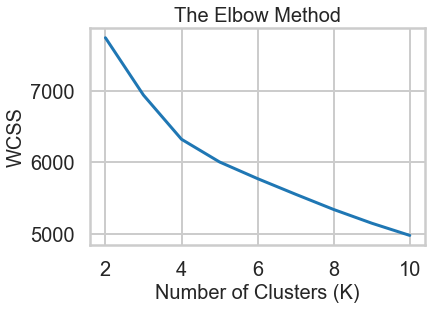

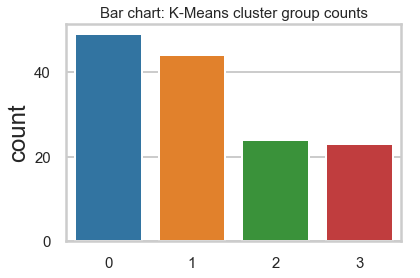

In [7]:
# Step 1: take the numpy matrix of feature(s) as X_cols: values within each column represent the feature.
X_cols = df_new.values

# Step 2: let's apply the feature scaling to standardize the range of values
sc_X = StandardScaler()
X_cols_std = sc_X.fit_transform(X_cols)

# Print the table matrix:
print(X_cols_std)

# Apply the K-Means cluster:
wcss=[]
for i in range(2,11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_cols_std)
    wcss.append(km.inertia_)
    
# Construct the Elbow method plot:
plt.figure()
plt.plot(range(2,11), wcss)
plt.title('The Elbow Method', fontsize=20)
plt.xlabel('Number of Clusters (K)', fontsize=20)
plt.ylabel('WCSS', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Fit K-Means cluster with the optimal K=4:
km = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_km = km.fit_predict(X_cols_std)
# Plot a bar chart: show number of points in each cluster
sns.countplot(y_km)
plt.title('Bar chart: K-Means cluster group counts', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Choosing the optimal K: The Silhouette Method ##
From the elbow method, it is hard to distinguish the optimal point where changes in WCSS is not so significant.
Therefore, we are going to apply the Silhouette method for assessing the optimal # of clusters. Silhouette score is computed on every single data point in every cluster. The Silhouette score ranges from -1 to +1 to indicate the level of reasonable groupings/structures.

n_clusters =  2 silhouette_avg_score 0.13919226867690543
n_clusters =  3 silhouette_avg_score 0.1353597665451171
n_clusters =  4 silhouette_avg_score 0.1377669275434942
n_clusters =  5 silhouette_avg_score 0.11440928835324904
n_clusters =  6 silhouette_avg_score 0.13308792861230836
n_clusters =  7 silhouette_avg_score 0.1269050709041292
n_clusters =  8 silhouette_avg_score 0.1310856799372231
n_clusters =  9 silhouette_avg_score 0.12949058652459344
n_clusters =  10 silhouette_avg_score 0.13915160285324216


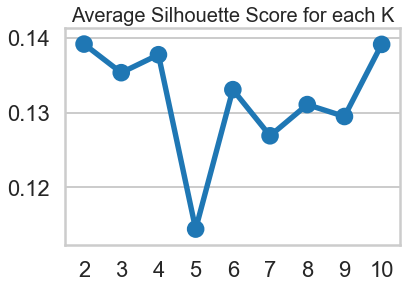

In [8]:
# Compute the Silhouette score for optimal K assessment:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Range of clusters: from 2 to 10;
rang_clust = list(range(2,11)) 
silhouette_scores = []

for n_clust in rang_clust:
    km = KMeans(n_clusters=n_clust, init='k-means++', random_state=0)
    km_labels = km.fit_predict(X_cols_std) #X_cols
    
    silhouette_avg = silhouette_score(X_cols_std, km_labels)
    silhouette_scores.append(silhouette_avg)
    print("n_clusters = ", n_clust,
         "silhouette_avg_score", silhouette_avg)

# Plot for average Silhouette score for each "K" cluster(s):
plt.figure()
plt.title('Average Silhouette Score for each K', fontsize=20)
sns.pointplot(x=rang_clust, y=silhouette_scores)
plt.show()

The optimal # of clusters (K=2) based on the given avg. score of silhouette (0.1392). Thus, Toronto community profile can be segmented based on four different neighborhood groups.

For n_clusters = 2 The average silhouette_score is: 0.13919226867690543


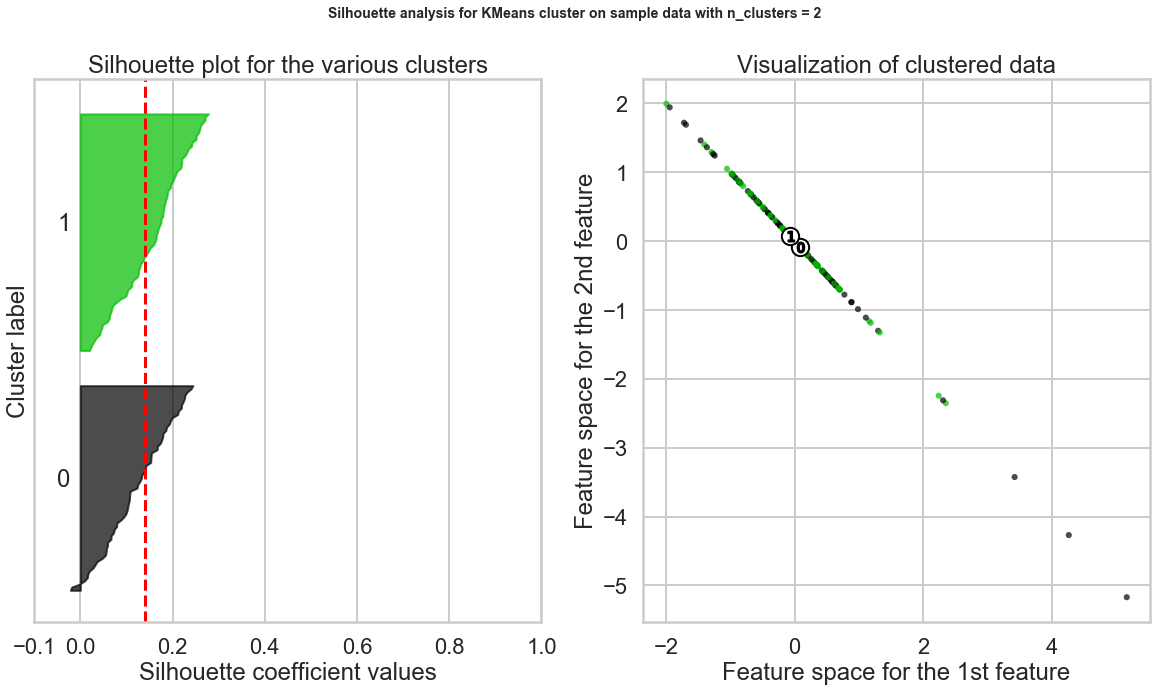

For n_clusters = 3 The average silhouette_score is: 0.1353597665451171


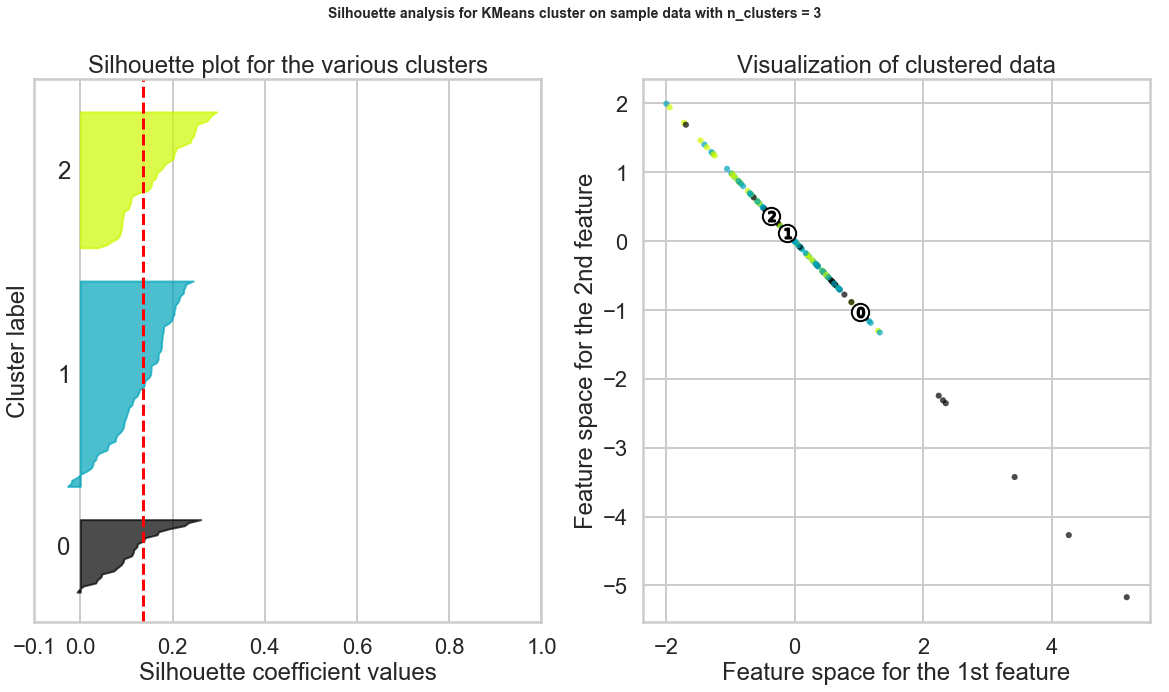

For n_clusters = 4 The average silhouette_score is: 0.1377669275434942


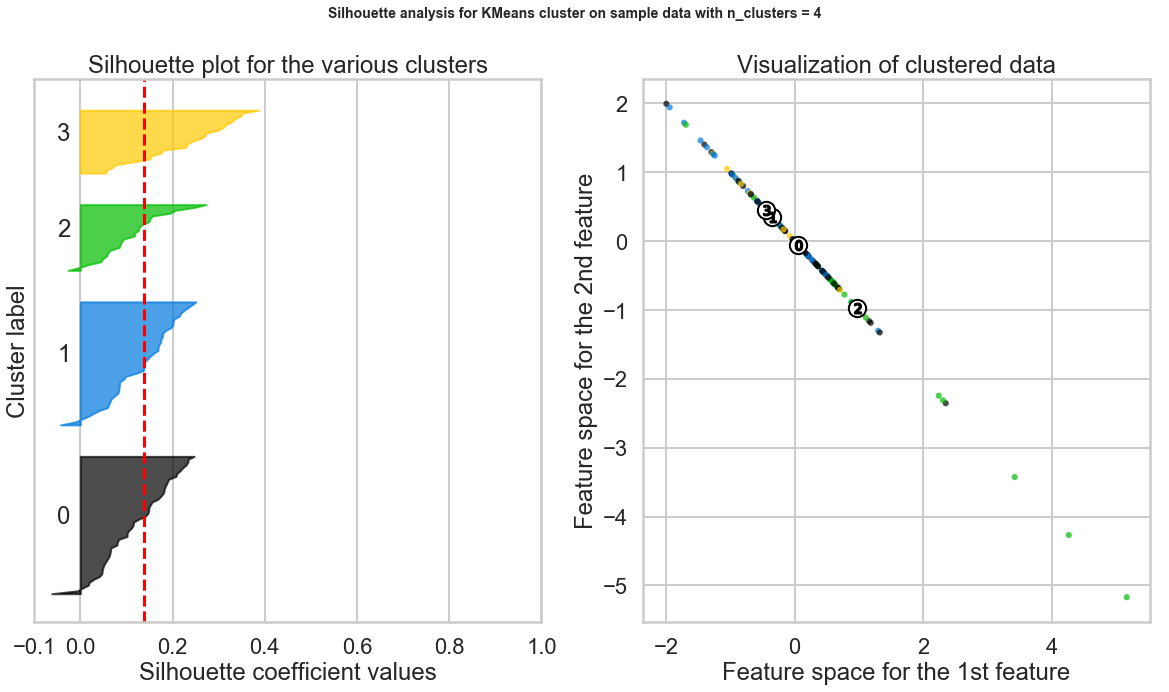

In [9]:
# Reduced range of clusters:
rang_clust = list(range(2,5)) 

# Silhouette and cluster plots for n_clusters:
for n_clust in rang_clust:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    # 1st sub-plot: Silhouette plot
    ax1.set_xlim([-0.1, 1])
    # Insert blank space between Silhouette plots: each cluster
    ax1.set_ylim([0, len(X_cols_std) + (n_clust + 1)*10])
    
    # Initialize the cluster with n_clust and a random number generator:
    km = KMeans(n_clusters=n_clust, init='k-means++', random_state=0)
    km_labels = km.fit_predict(X_cols_std)
    
    # Silhouette_score shows the average value: density and separation of formed cluster(s)
    silhouette_avg = silhouette_score(X_cols_std, km_labels)
    print("For n_clusters =", n_clust,
         "The average silhouette_score is:", silhouette_avg)
    
    # Compute the silhouette score for each sample:
    sample_silhouette_values = silhouette_samples(X_cols_std, km_labels)
    
    y_lower = 10
    for i in range(n_clust):
        # Aggreate the silhouette scores for samples belonging to
        # cluster i and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[km_labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.spectral(float(i) / n_clust)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 
                          0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers in the middle:
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lwoer for next plot
        y_lower = y_upper + 10 # 10 for the 0 samples;
    
    ax1.set_title('Silhouette plot for the various clusters')
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster label')
    
    # The vertical line for avrage silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
    
    ax1.set_yticks([]) # clear the y-axis labels/ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd plot showing the actual formed clusters
    colors = cm.spectral(km_labels.astype(float) / n_clust)
    ax2.scatter(X_cols_std[:,0], X_cols_std[:,1], marker='.', s=150, lw=0, alpha=0.7, c=colors, edgecolor='k')
    
    # Labeling the clusters
    centers = km.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:,0], centers[:,1], marker='o',
               c='white', alpha=1, s=300, edgecolor='k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                   s=100, edgecolor='k')
        
    ax2.set_title('Visualization of clustered data')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('Feature space for the 2nd feature')
    
    plt.suptitle(('Silhouette analysis for KMeans cluster on sample data '
                'with n_clusters = %d' % n_clust),
               fontsize=14, fontweight='bold')
    plt.show()   

## Hierarchical Clustering ##

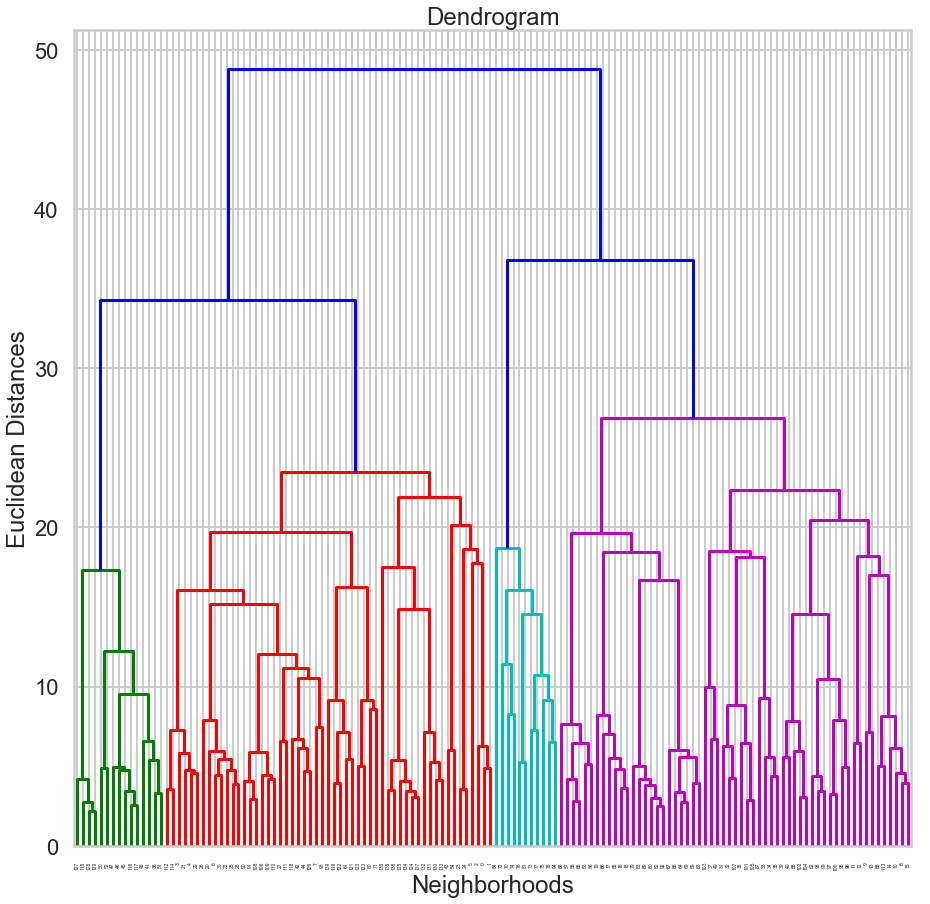

In [10]:
# Step 1: using the dendograms to find the optimal number of clusters (K)
import scipy.cluster.hierarchy as sch
fig = plt.figure(figsize=(15,15))
dn = sch.dendrogram(sch.linkage(X_cols_std, method = 'ward')) 
plt.title ('Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Euclidean Distances')
plt.show() 

In [11]:
# Step 2: fitting hierarchical clustering to the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_cols_std)

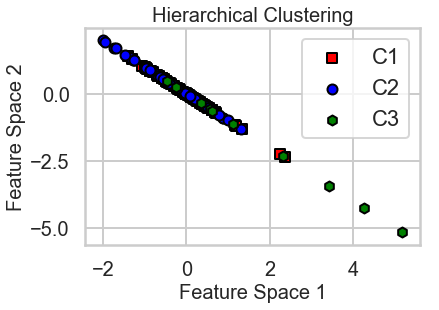

In [12]:
# Step 3: visualizing the clusters 
plt.scatter(X_cols_std[y_hc == 0, 0], 
            X_cols_std[y_hc == 0, 1], 
            s = 100, c = 'red', 
            marker='s', edgecolor='black',
            label = 'C1')
plt.scatter(X_cols_std[y_hc == 1, 0], 
            X_cols_std[y_hc == 1, 1], 
            s = 100, c = 'blue', 
            marker='o', edgecolor='black',
            label = 'C2')
plt.scatter(X_cols_std[y_hc == 2, 0], 
            X_cols_std[y_hc == 2, 1], 
            s = 100, c = 'green', 
            marker='h', edgecolor='black',
            label = 'C3')
#plt.scatter(X_cols_std[y_hc == 3, 0], 
#            X_cols_std[y_hc == 3, 1], 
#            s = 100, c = 'magenta', 
#            marker='h', edgecolor='black',
#            label = 'C4')
plt.title('Hierarchical Clustering', fontsize=20)
plt.xlabel('Feature Space 1', fontsize=20)
xt = plt.xticks(fontsize=20)        
plt.ylabel('Feature Space 2', fontsize=20)
yt = plt.yticks(fontsize=20)
plt.legend()
plt.show()

## Visualize Clusters using PCA: K-Means ##
We have about 140 neighborhoods (data points) each containing 66 features (dimensions). Principal Component Analysis (PCA) will help us avoid the curse of dimensionality by reducing dimensions into a few dimensions (i.e., 2-D). 

In [13]:
# Apply K-Means clustering
km = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(X_cols_std)
km_labels = km.labels_

# Apply PCA decomposition into 2 components:
pca = PCA(n_components=2) # specify into 2 components
X_cols_pca = pca.fit_transform(X_cols_std) # fit and transform into PCA components

# Create a PCA decomposed reduced dimensions and named two components:x, y
df_pca = pd.DataFrame(X_cols_pca)
df_pca.columns = ['X','Y']
df_pca.head()

,X,Y
0,-3.674015,1.447246
1,-4.112593,4.522216
2,-3.375898,2.757807
3,-1.700004,1.638334
4,-1.672826,3.489731


In [14]:
# Create a merged DataFrame: neighborhood name and label
df_merged = df_pca.merge(df['nh_name'].reset_index(), left_index=True, right_index=True).drop('index', axis=1)
# Bind predicted cluster label column:
df_merged['label'] = km_labels
# Print the dataframe:
df_merged.head()

,X,Y,nh_name,label
0,-3.674015,1.447246,West Humber-Clairville,0
1,-4.112593,4.522216,Mount Olive-Silverstone-Jamestown,0
2,-3.375898,2.757807,Thistletown-Beaumond Heights,0
3,-1.700004,1.638334,Rexdale-Kipling,0
4,-1.672826,3.489731,Elms-Old Rexdale,0


In [15]:
# Write a function: plot the PCA scatter plot
def plot_pca_scatter(x,y,label,df,header):
    sns.lmplot(x=x, y=y, hue=label, data=df, fit_reg=False)
    plt.title('PCA Scatter Plot: '+header)

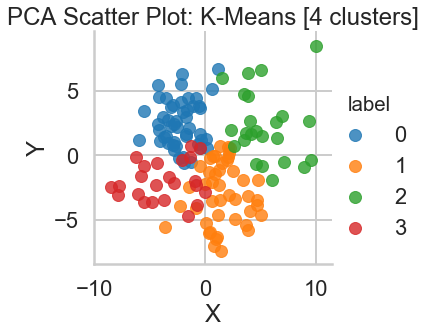

In [16]:
# Visualize the PCA cluster: scatter plot - K-Means 4 clusters
plot_pca_scatter('X','Y','label',df_merged,'K-Means [4 clusters]')

,X,Y,nh_name,label,nh_id,ward_id,ward_name,demo_pct_males,demo_pct_females,inc_pct_lico_at,...,deprivation_status,dependency_status,ethnic_status,lico_at_grp_label,ed_visits_grp_label,alc_rate_grp_label,hosp_rate_grp_label,injury_rate_grp_label,birth_rate_grp_label,chronic_4_cond_rate_grp_label
0,-3.674015,1.447246,West Humber-Clairville,1,1,2,Etobicoke North,0.505515,0.494485,0.137462,...,4-somewhat deprived,3-neutral dependent,5-most ethnic concentrated,Wealthy,Low,Low,Medium,Low,Medium,Low
1,-4.112593,4.522216,Mount Olive-Silverstone-Jamestown,1,2,1,Etobicoke North,0.490776,0.509224,0.217822,...,5-most deprived,2-little dependent,5-most ethnic concentrated,Neutral,Medium,Low,Medium,Low,High,Low
2,-3.375898,2.757807,Thistletown-Beaumond Heights,1,3,1,Etobicoke North,0.495343,0.504657,0.146739,...,5-most deprived,5-most dependent,4-somewhat ethnic concentrated,Wealthy,Medium,Medium,High,Medium,Medium,Medium
3,-1.700004,1.638334,Rexdale-Kipling,1,4,2,Etobicoke North,0.489285,0.510715,0.158860,...,4-somewhat deprived,4-somewhat dependent,3-neutral ethnic concentrated,Neutral,Medium,Low,High,Medium,Medium,Medium
4,-1.672826,3.489731,Elms-Old Rexdale,1,5,2,Etobicoke North,0.492390,0.507610,0.179270,...,5-most deprived,2-little dependent,4-somewhat ethnic concentrated,Neutral,Medium,Low,High,Medium,Medium,Low


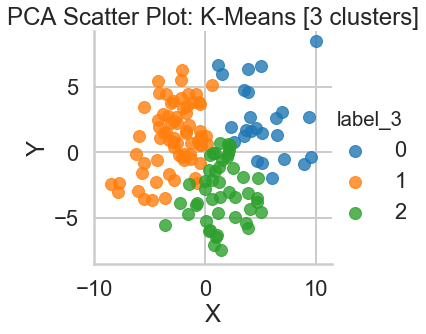

In [17]:
# Re-fit K-Means using 3 clusters:
df_merged['label_3'] = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(X_cols_std).labels_
# Visualize the PCA cluster: scatter plot - K-Means 3 clusters
plot_pca_scatter('X','Y','label_3',df_merged,'K-Means [3 clusters]')

# Assume 3 clusters: label = label_3
df_merged['label'] = df_merged['label_3']
df_merged = df_merged.drop(['label_3'], axis=1)

# Reviewed the clustered data points by merge with other community health profile features:
df_review = df_merged.merge(df, on='nh_name')
df_review.head()

## Visualize Clusters using PCA: Hierarchical ##

In [18]:
# Apply Hierarchical clustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
hc_labels = hc.fit_predict(X_cols_std)

# Create a merged DataFrame: neighborhood name and label - Hierarchical Clustering
df_merged_hc = df_pca.merge(df['nh_name'].reset_index(), left_index=True, right_index=True).drop('index', axis=1)
# Bind predicted cluster label column:
df_merged_hc['label'] = hc_labels
# Print the dataframe:
df_merged_hc.head()

,X,Y,nh_name,label
0,-3.674015,1.447246,West Humber-Clairville,0
1,-4.112593,4.522216,Mount Olive-Silverstone-Jamestown,0
2,-3.375898,2.757807,Thistletown-Beaumond Heights,0
3,-1.700004,1.638334,Rexdale-Kipling,0
4,-1.672826,3.489731,Elms-Old Rexdale,0


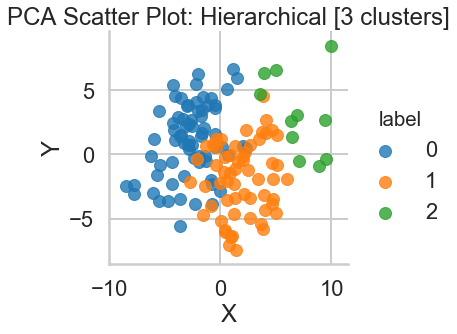

In [19]:
# Visualize the PCA cluster: scatter plot - Hierarchical 3 clusters
plot_pca_scatter('X','Y','label',df_merged_hc,'Hierarchical [3 clusters]')

,X,Y,nh_name,label,nh_id,ward_id,ward_name,demo_pct_males,demo_pct_females,inc_pct_lico_at,...,deprivation_status,dependency_status,ethnic_status,lico_at_grp_label,ed_visits_grp_label,alc_rate_grp_label,hosp_rate_grp_label,injury_rate_grp_label,birth_rate_grp_label,chronic_4_cond_rate_grp_label
0,-3.674015,1.447246,West Humber-Clairville,1,1,2,Etobicoke North,0.505515,0.494485,0.137462,...,4-somewhat deprived,3-neutral dependent,5-most ethnic concentrated,Wealthy,Low,Low,Medium,Low,Medium,Low
1,-4.112593,4.522216,Mount Olive-Silverstone-Jamestown,1,2,1,Etobicoke North,0.490776,0.509224,0.217822,...,5-most deprived,2-little dependent,5-most ethnic concentrated,Neutral,Medium,Low,Medium,Low,High,Low
2,-3.375898,2.757807,Thistletown-Beaumond Heights,1,3,1,Etobicoke North,0.495343,0.504657,0.146739,...,5-most deprived,5-most dependent,4-somewhat ethnic concentrated,Wealthy,Medium,Medium,High,Medium,Medium,Medium
3,-1.700004,1.638334,Rexdale-Kipling,1,4,2,Etobicoke North,0.489285,0.510715,0.158860,...,4-somewhat deprived,4-somewhat dependent,3-neutral ethnic concentrated,Neutral,Medium,Low,High,Medium,Medium,Medium
4,-1.672826,3.489731,Elms-Old Rexdale,1,5,2,Etobicoke North,0.492390,0.507610,0.179270,...,5-most deprived,2-little dependent,4-somewhat ethnic concentrated,Neutral,Medium,Low,High,Medium,Medium,Low


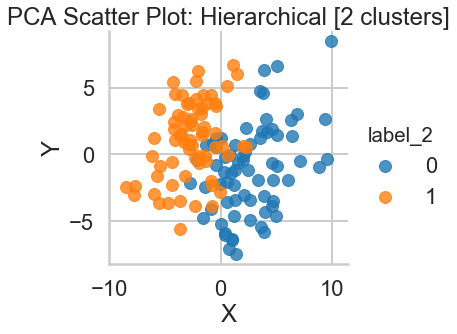

In [20]:
# Re-fit the Hierarchical cluster using 2 clusters:
df_merged_hc['label_2'] = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward').fit_predict(X_cols_std)
# Visualize the PCA cluster: scatter plot - Hierarchical 2 clusters
plot_pca_scatter('X','Y','label_2',df_merged_hc,'Hierarchical [2 clusters]')

# Assume 2 clusters: label = label_2
df_merged_hc['label'] = df_merged_hc['label_2']
df_merged_hc = df_merged_hc.drop(['label_2'], axis=1)

# Reviewed the clustered data points by merge with other community health profile features:
df_review_hc = df_merged_hc.merge(df, on='nh_name')
df_review_hc.head()

In [21]:
# Write a function to plot: bar charts
def plot_bar_chart(x,y,df,var,label):
    plt.figure(figsize=(20,8))
    sns.countplot(x=x, hue=y, data=df)
    plt.title('Bar Chart: ' + var)
    plt.xticks(rotation=90)
    plt.xlabel(label)
    plt.legend(loc='upper right')
    
# Write a function to plot: bar charts by ordinal categorical order
def plot_bar_chart_order(x,y,df,var,label,order):
    plt.figure(figsize=(20,8))
    sns.countplot(x=x, hue=y, data=df, order=order)
    plt.title('Bar Chart: ' + var)
    plt.xticks(rotation=90)
    plt.xlabel(label)
    plt.legend(loc='upper right')

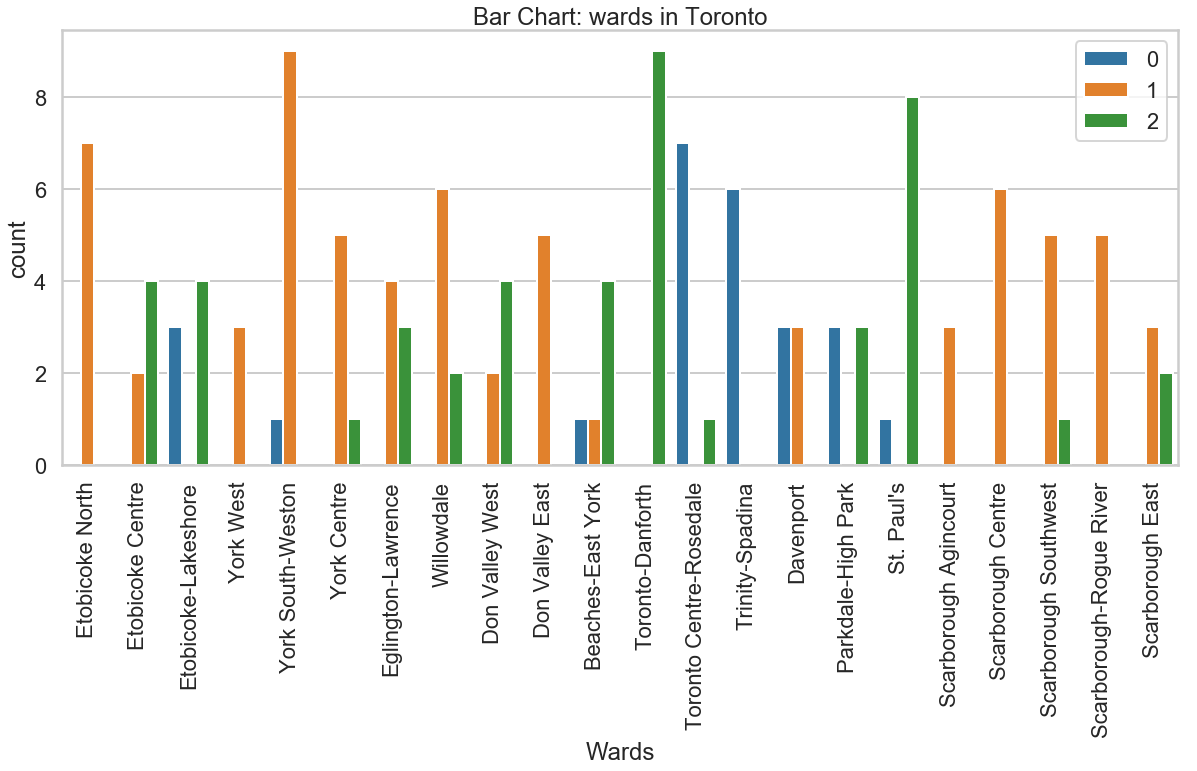

In [22]:
# Plot bar charts on City of Toronto Wards and cluster labels:
plot_bar_chart('ward_name','label', df_review, 'wards in Toronto', 'Wards')
plt.show()

**Bar Chart Interpreation: at ward level in Toronto**

Summary: in Toronto, following # of wards are assigned on each neighborhood group
* group 0 = 8 wards
* group 1 = 16 wards
* group 2 = 13 wards

From the above bar charts, we can draw couple of interesting observations:
* York South-Weston ward was predominant on neighborhood group 1 and small # of neighborhood group 0.
* Toronto-Danforth ward was predominant on neighborhood group 2 and no neighborhood groups of 0 and 1.
* Toronto Centre-Rosedale ward was predominant on neighborhood group 0 followed by neighborhood group 2.

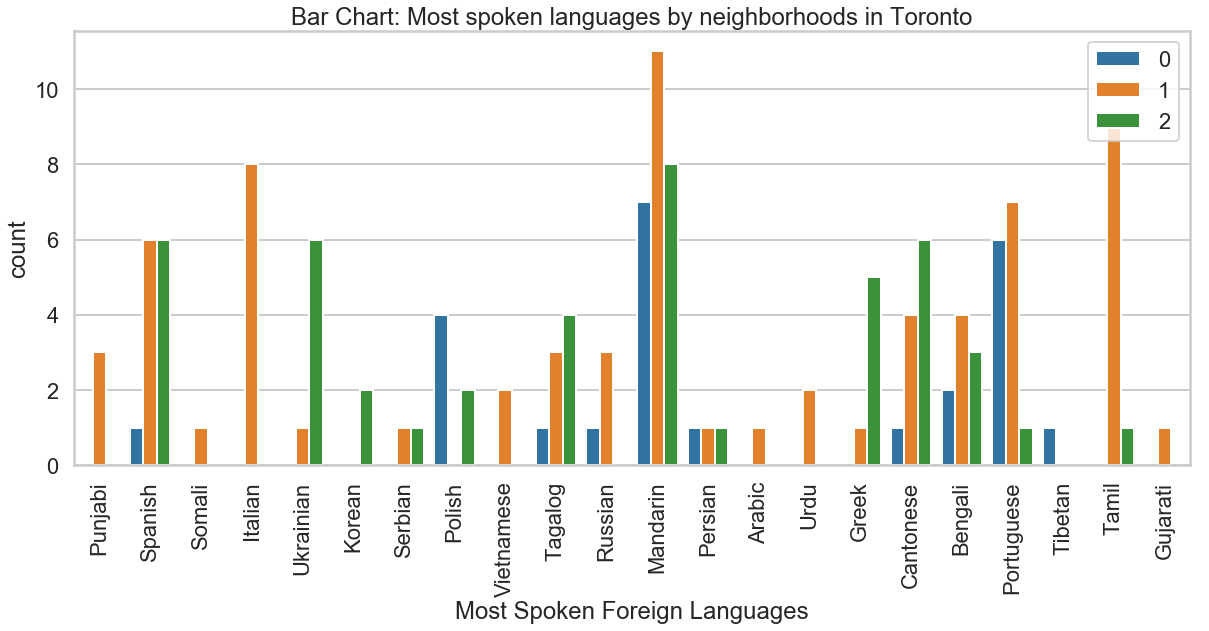

In [23]:
# Plot bar charts on most spoken languages and cluster labels:
plot_bar_chart('demo_most_sponken_lang','label', df_review, 
               'Most spoken languages by neighborhoods in Toronto', 'Most Spoken Foreign Languages')
plt.show()

**Bar Chart Interpreation: most spoken foreign language by neighborhood area(s)**

Note: Mandarin spoken area was predominant in Toronto neighborhoods followed by Tamil, Portuguese, Cantonese, Spanish and etc.
* Mandarin spoken area(s), all three-neighborhood group(s) with label 0, 1 and 2 were found.
* Also, Portuguese, Spanish, Cantonese, Bengali, Tagalog, etc. spoken area(s) had neighborhoods with all 3 labels.
* Tibetan spoken area(s) had only neighborhood group(s) with label 0.
* Urdu, Arabic, Somali and Punjabi spoken area(s) had only neighborhood group(s) with label 1.
* Korean spoken area(s) had only neighborhood group with label 2.

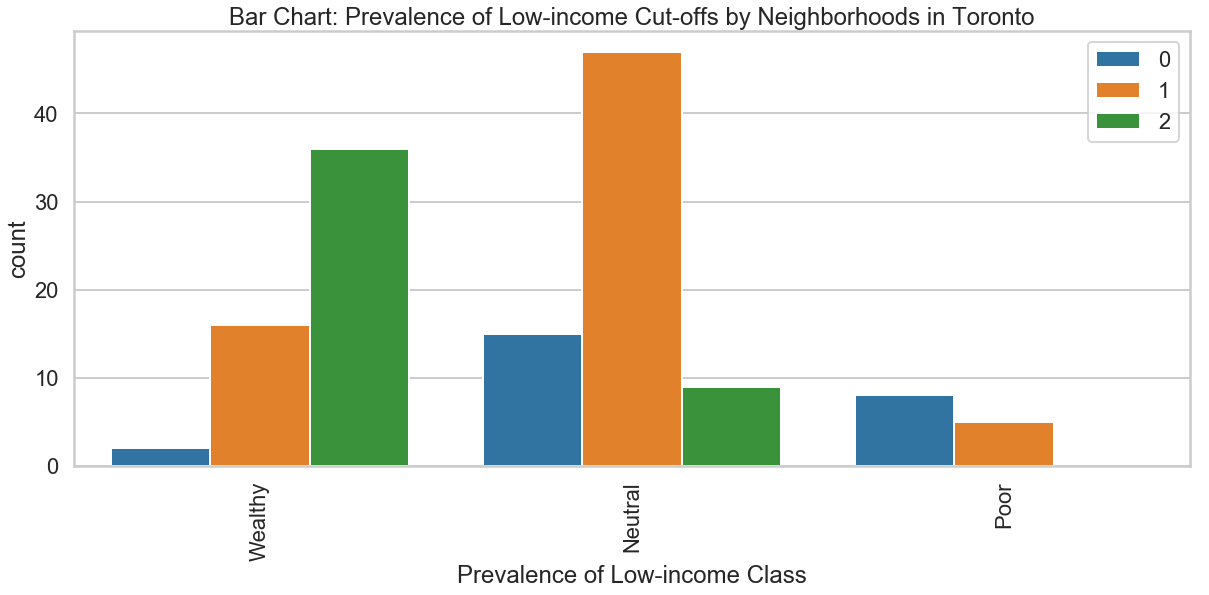

In [24]:
# Plot bar charts on % of low-income cut-off after tax and cluster labels:
plot_bar_chart('lico_at_grp_label','label', df_review, 
               'Prevalence of Low-income Cut-offs by Neighborhoods in Toronto', 'Prevalence of Low-income Class')
plt.show()

**Bar Chart Interpreation: prevalence of low income based on the low-income cut-offs after tax groups**
* Neighborhood group with label 0 has the highest prevalence of low income based on neighborhood counts [relative poor].
* Neighborhood group with label 1 has neutral level - prevalence of low income based on neighborhood counts [relative middle].
* Neighborhood group with label 2 has the lowest prevalence of low income based on neighborhood counts [relative wealthy].

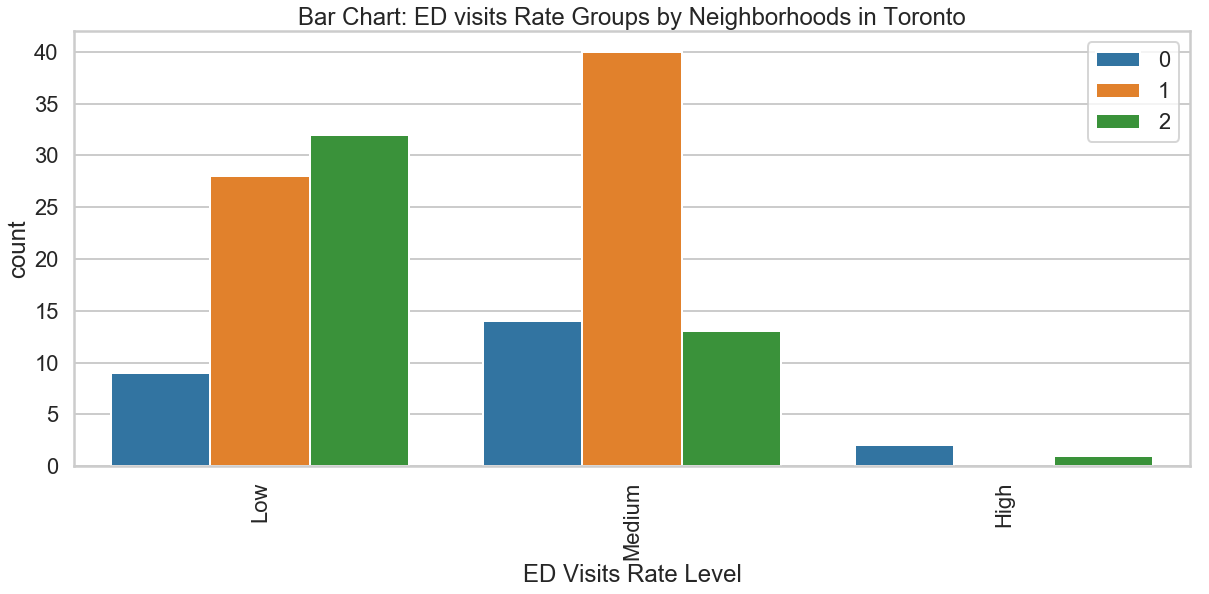

In [25]:
# Plot bar charts on  and cluster labels:
plot_bar_chart('ed_visits_grp_label','label', df_review, 
               'ED visits Rate Groups by Neighborhoods in Toronto', 'ED Visits Rate Level')

**Bar Chart Interpreation: unscheduled ED visits rate per 1000 groups**
* Neighborhood group with label 0 has the highest count of high ED visits rate followed by label 2 [high ED visits].
* Neighborhood group with label 1 has the highest count of medium ED visits rate [medium ED visits]
* Neighborhood group with label 2 has the highest count of low ED visits rate followed by label 1 [low ED visits].

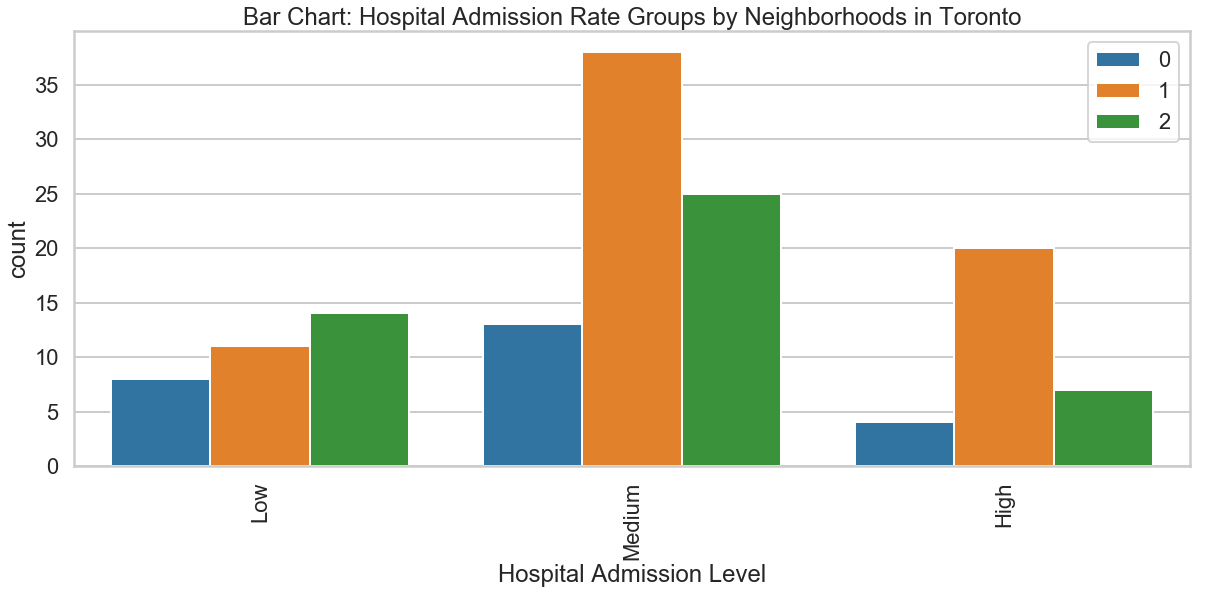

In [26]:
# Plot bar charts on and cluster labels:
plot_bar_chart('hosp_rate_grp_label','label', df_review, 
               'Hospital Admission Rate Groups by Neighborhoods in Toronto', 'Hospital Admission Level')

**Bar Chart Interpreation: hospital admission rate per 1000 groups**
* Neighborhood group with label 0 has higher counts of medium level hospital admissions than other two levels.
* Neighborhood group with label 1 has the highest count of high and medium hospital admissions among 3 labels.
* Neighborhood group with label 2 has the highest count of low hospital admissions among 3 labels.

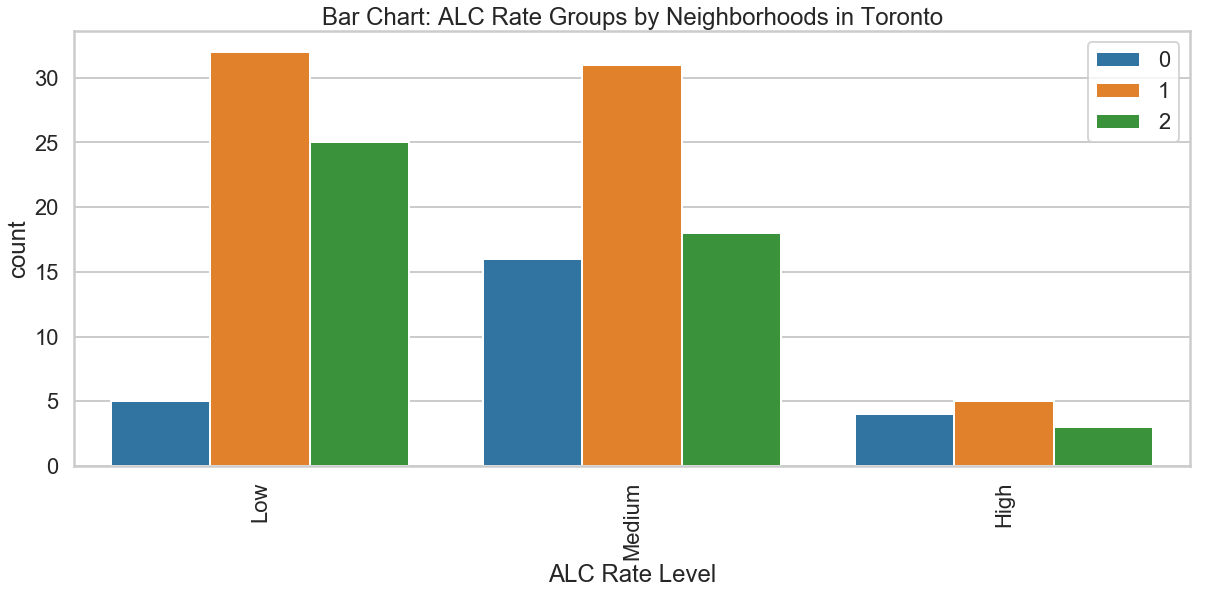

In [27]:
# Plot bar charts on and cluster labels:
plot_bar_chart('alc_rate_grp_label','label', df_review, 
               'ALC Rate Groups by Neighborhoods in Toronto', 'ALC Rate Level')

**Bar Chart Interpreation: Alternative Level of Care rate per 100 groups**
* Neighborhood group with label 0 has the highest count of medium ALC rate among 3 neighborhood groups.
* Neighborhood group with label 1 has the highest count of low ALC rate across the 3 different ALC rate levels.
* Neighborhood group with label 1 has the highest count of high ALC rate among 3 neighborhood groups.
* Neighborhood group with label 2 has the highest count of low ALC rate followed by medium and high.

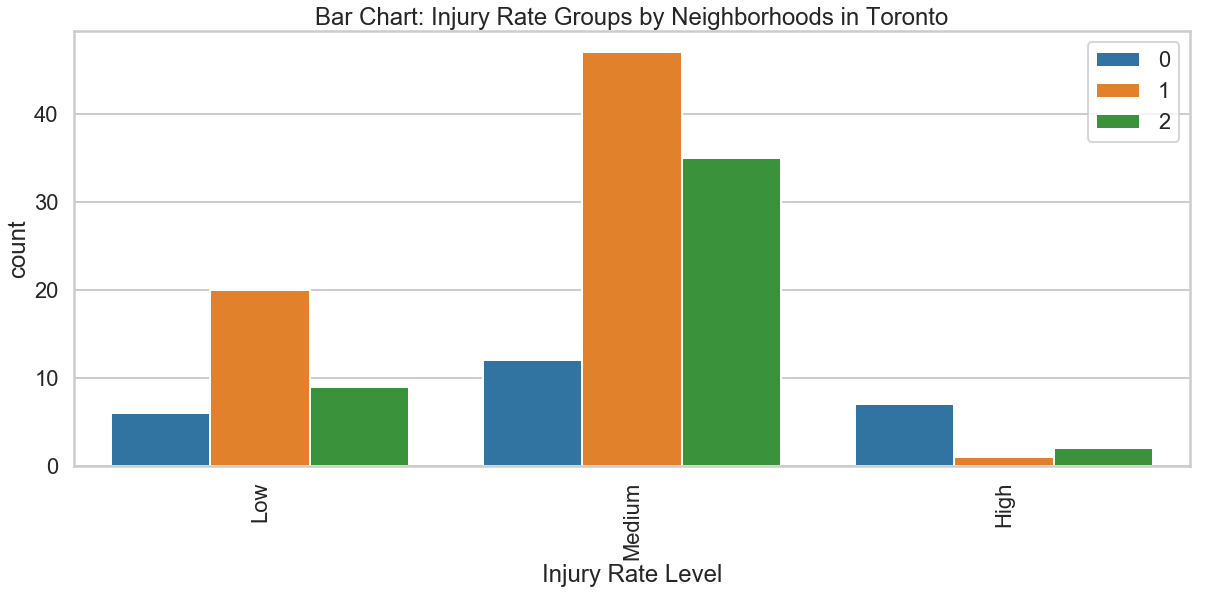

In [28]:
# Plot bar charts on and cluster labels:
plot_bar_chart('injury_rate_grp_label','label', df_review, 
               'Injury Rate Groups by Neighborhoods in Toronto', 'Injury Rate Level')

**Bar Chart Interpreation: Injury rate per 100 groups**
* Low injury rate: counts of neighborhood group label 0 < 2 < 1 --> [group 1]
* Medium injury rate: counts of neighborhood group label 0 < 2 < 1 --> [group 1]
* High injury rate: counts of neighborhood group label 1 < 2 < 0 --> [group 0]

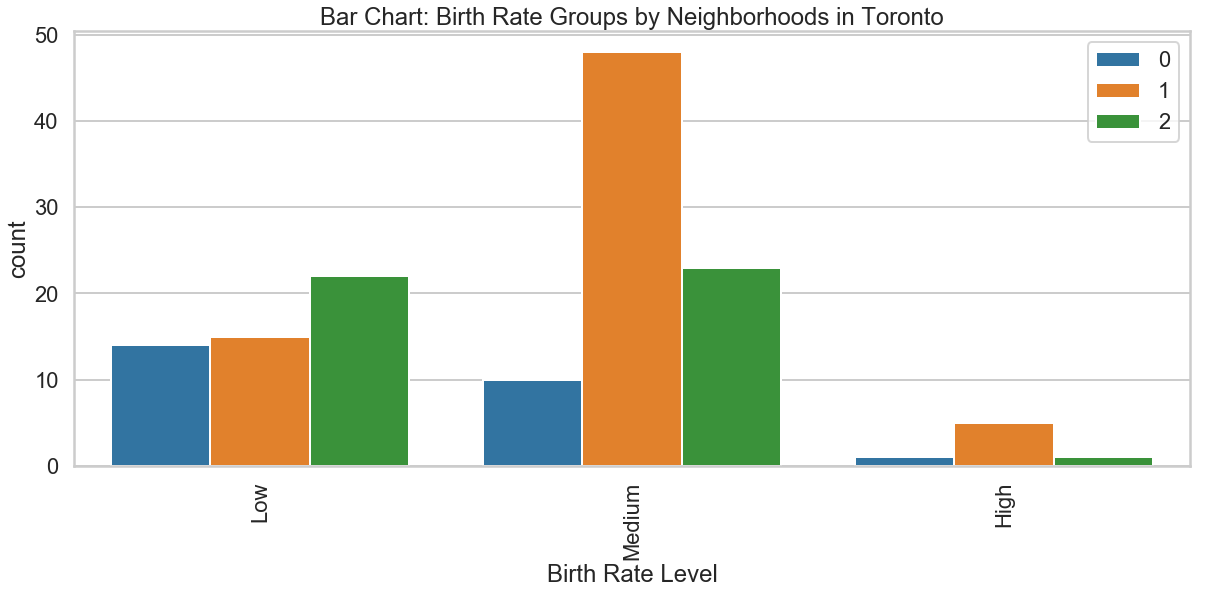

In [29]:
# Plot bar charts on and cluster labels:
plot_bar_chart('birth_rate_grp_label','label', df_review, 
               'Birth Rate Groups by Neighborhoods in Toronto', 'Birth Rate Level')

**Bar Chart Interpreation: Birth rate per 1000, women aged 15-49 groups**
* Low birth rate: counts of neighborhood group label 0 < 1 < 2 --> [group 2] 
* Medium birth rate: counts of neighborhood group label 0 < 2 < 1 --> [group 1] 
* High birth rate: counts of neighborhood group label 2 < 0 < 1 --> [group 2] 

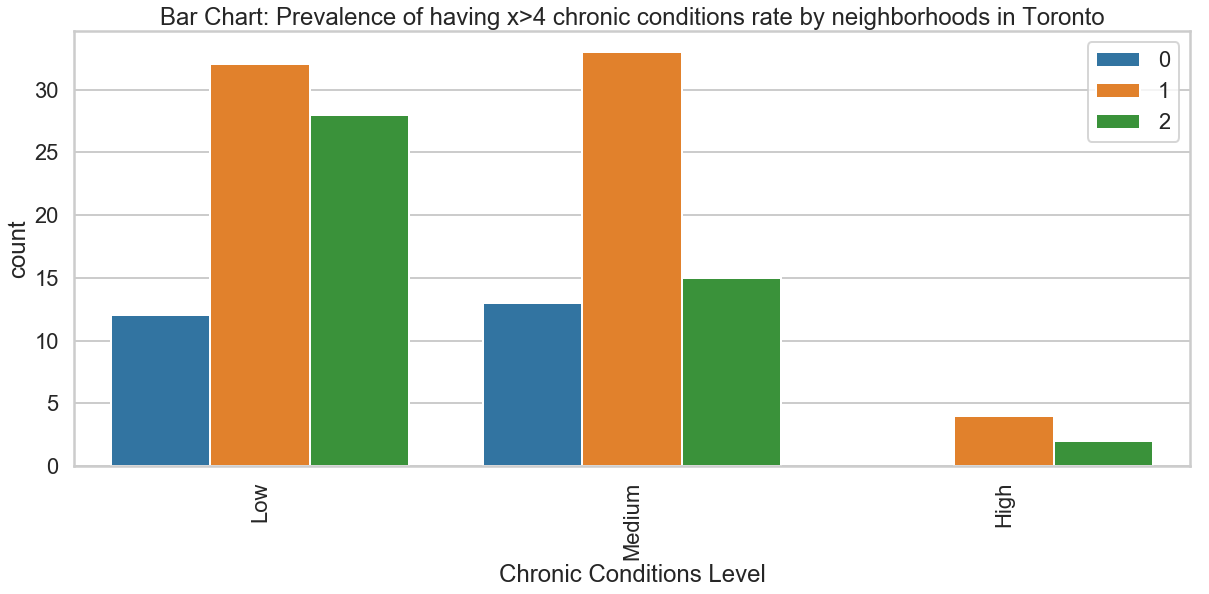

In [30]:
# Plot bar charts on  and cluster labels:
plot_bar_chart('chronic_4_cond_rate_grp_label','label', df_review, 
               'Prevalence of having x>4 chronic conditions rate by neighborhoods in Toronto', 'Chronic Conditions Level')

**Bar Chart Interpreation: prevalence of having more than 4 chronic conditions rate per 1000 groups**
* Neighborhood group with label 1 has the highest count for medium prevalence of having more than 4 chronic conditions across different chronic conditions level [somewhat unhealthy].
* Neighborhood group with label 2 has the highest count for low prevalence of having more than 4 chronic conditions across different chronic conditions level [healthy].

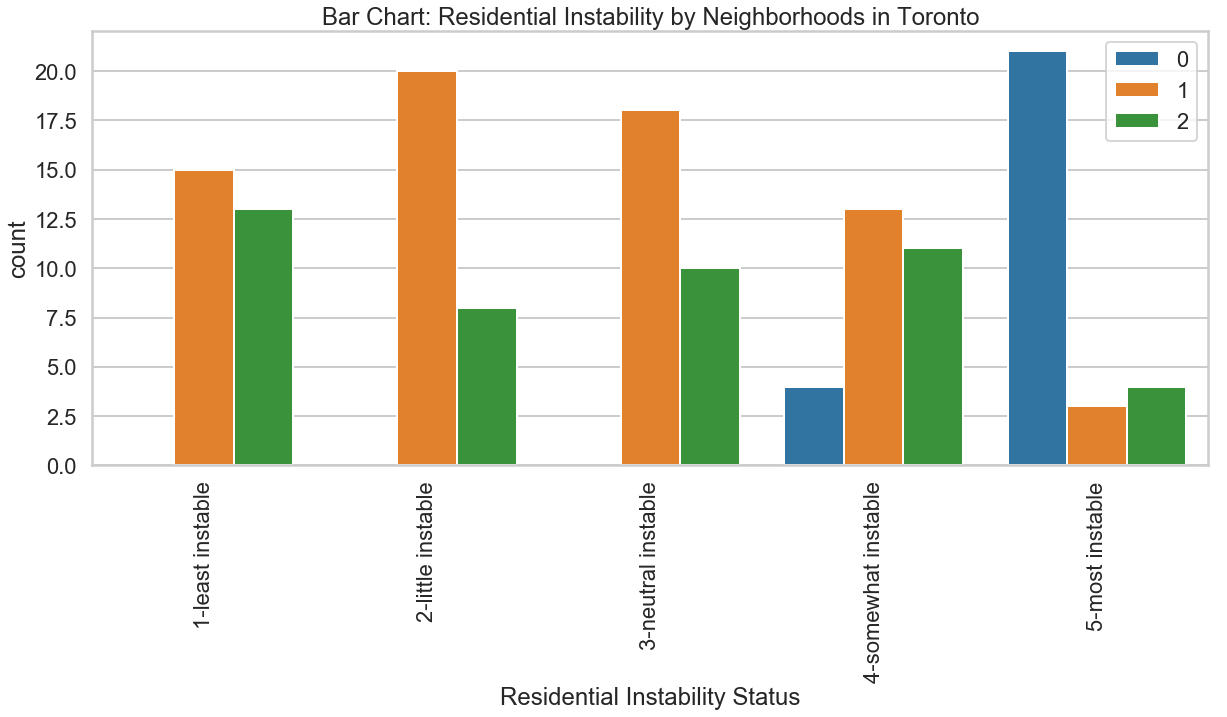

In [31]:
# Plot bar charts on residential instability and cluster labels:
plot_bar_chart_order('instability_status','label', df_review, 'Residential Instability by Neighborhoods in Toronto',
                     'Residential Instability Status', order=['1-least instable', '2-little instable',
                     '3-neutral instable', '4-somewhat instable', '5-most instable'])
plt.show()

**Bar Chart Interpreation: residential instability groups in Toronto**
* Neighborhood group label 0 represents areas where people most likely to experience family or housing instability problems.
* Neighborhood groups with label 1 and 2 represent areas where people least likely to experience family or housing instability problems.

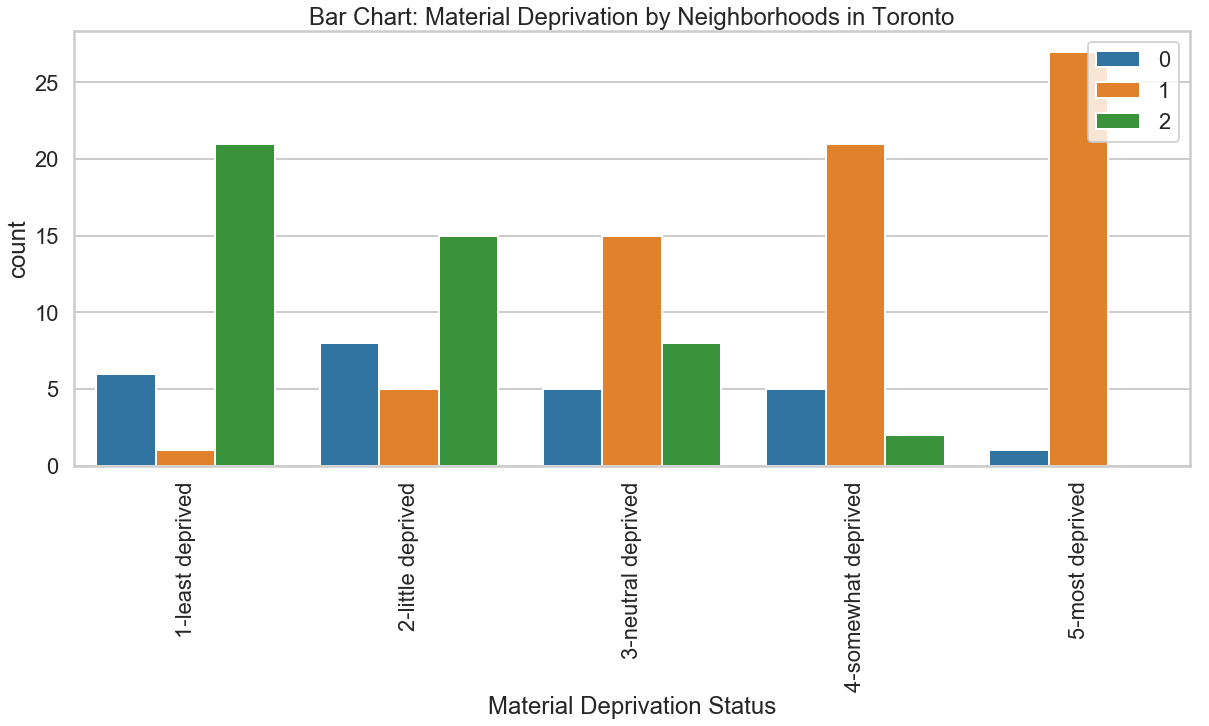

In [32]:
# Plot bar charts on material deprivation and cluster labels:
plot_bar_chart_order('deprivation_status','label', df_review, 'Material Deprivation by Neighborhoods in Toronto',
                     'Material Deprivation Status', order=['1-least deprived', '2-little deprived',
                     '3-neutral deprived','4-somewhat deprived','5-most deprived'])
plt.show()

**Bar Chart Interpreation: material deprivation groups in Toronto**
* Neighborhood groups with label 0 represent areas where people experience neutral poverty (inability to access basic needs: food, income and education).
* Neighborhood groups with label 1 represent areas where people most likely to experience poverty (inability to access basic needs: food, income and education).
* Neighborhood groups with label 2 represent areas where people least likely to experience poverty (inability to access basic needs: food, income and education).

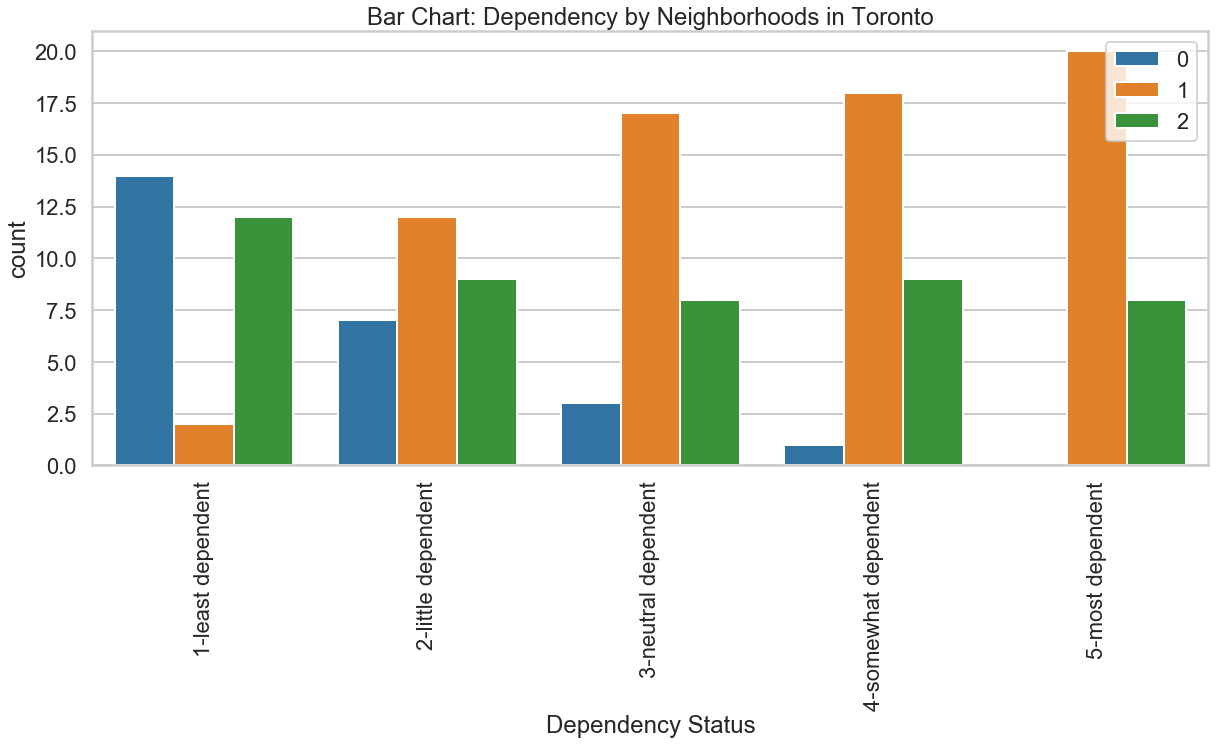

In [33]:
# Plot bar charts on dependency and cluster labels:
plot_bar_chart_order('dependency_status','label', df_review, 'Dependency by Neighborhoods in Toronto', 
                     'Dependency Status', order=['1-least dependent', '2-little dependent','3-neutral dependent',
                     '4-somewhat dependent', '5-most dependent'])
plt.show()

**Bar Chart Interpreation: dependency groups in Toronto**
* Neighborhood group with label 0 account for areas where people being the least dependent on subsidies (i.e., do not have income from employment).
* Neighborhood group with label 1 account for areas where people being the most dependent on subsidies (i.e., do not have income from employment).
* Neighborhood group with label 2 account for areas where people being somewhat dependent on subsidies (i.e., do not have income from employment).

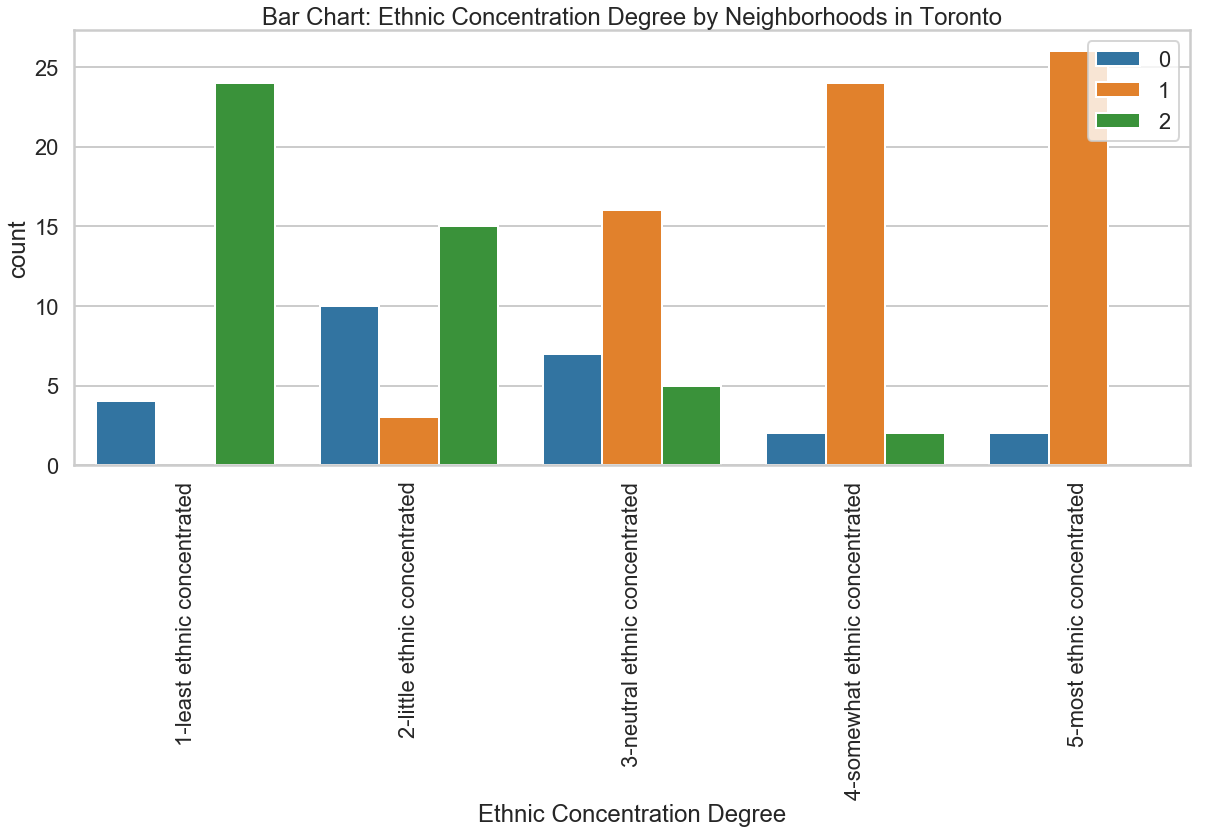

In [34]:
# Plot bar charts on ethnic concentration and cluster labels:
plot_bar_chart_order('ethnic_status','label', df_review, 'Ethnic Concentration Degree by Neighborhoods in Toronto',
                     'Ethnic Concentration Degree', order=['1-least ethnic concentrated', '2-little ethnic concentrated',
                     '3-neutral ethnic concentrated','4-somewhat ethnic concentrated', '5-most ethnic concentrated'])
plt.show()

**Bar Chart Interpreation: ethnic concentration status in Toronto**
* Neighborhood group label 0 represents areas where medium degree of immigrants or people belonging to a 'visible minority' group live.
* Neighborhood group label 1 represents areas where the most immigrants or people belonging to a 'visible minority' group live.
* Neighborhood group label 2 represents areas where the least immigrants or people belonging to a 'visible minority' group live.

In [35]:
# Check the lengh of matrix w.r.t: columns
len(X_cols_std[0])

65

## Initialize a new PCA model ##

We are going to used the explained variance component to plot the optimal # of clusters determined by PCA model!

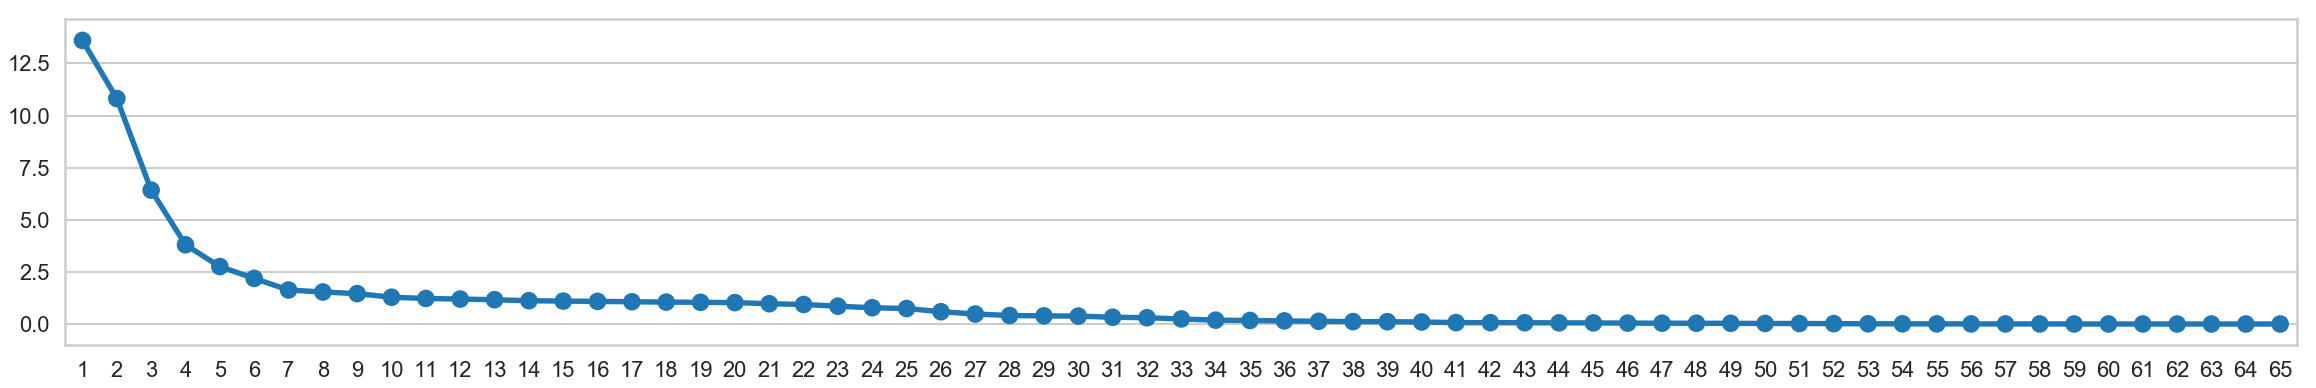

In [36]:
# Initialize: new PCA model
pca = sklearn.decomposition.PCA()
pca.fit(X_cols_std)

# Compute the explained variance
pca.explained_variance_

# Plot a explained variance:
plt.figure(figsize=(40,6))
sns.pointplot(x=list(range(1,66)), y=pca.explained_variance_)

From the above explained variance plot, optimum elbow point for # of pca components seems n=4. Thus, PCA algorithm suggests that the optimal number of components should be 4 instead of 2!